<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [20]:
import numpy as np 
from sklearn import metrics
from clustering_utils import *
from eda_utils import *
from myutils_V6 import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

####################################
### string normalized
####################################


from gensim.utils import tokenize
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords

def normal_string(x):
    x = remove_stopwords(x)
#     x = " ".join(preprocess_string(x))
    x = " ".join(word_tokenize(x, preserve_line=False)).strip()
    return x


In [21]:
# seeds = 2021
# np.random.seed(seeds)

# import pandas as pd
# train = pd.read_json('../data/structured_train.json')
# test = pd.read_json('../data/structured_test.json')

# train.sample(frac=1, random_state=seeds).reset_index(drop=True)
# test.sample(frac=1, random_state=seeds).reset_index(drop=True)


# # train = train.groupby('label').sample(50, random_state=seeds)
# # test = test.groupby('label').sample(50, random_state=seeds)

# ####################################
# ### columns selection
# ####################################
# select_cols = ["global_index", "doc_path", "label",
#                "reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two",
#                "Subject", "From", "Lines", "Organization", "contained_emails", "long_string", "text", "error_message"
#                ]
# print("\nmay use cols: \n", select_cols)
# train = train[select_cols]
# train[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]] = train[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]].astype(str)

# test = test[select_cols]
# test[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]] = test[["reply", "reference_one", "reference_two", "tag_reply", "tag_reference_one", "tag_reference_two", "Subject", "From", "Lines", "Organization"]].astype(str)



# ####################################
# ### upsampling for small class
# ####################################
# group_size = train.groupby('label').size()
# mean_size = int(group_size.mean())
# small_groups = group_size[group_size<mean_size].index.tolist()

# train_small_groups = train[train['label'].isin(small_groups)].groupby('label').sample(n=mean_size, replace=True, random_state=seeds)
# train_large_groups = train[~train['label'].isin(small_groups)]
# upsampling_train = pd.concat([train_small_groups, train_large_groups], axis=0)
# upsampling_group_size = upsampling_train.groupby('label').size()
# upsampling_info = pd.concat([group_size, upsampling_group_size, upsampling_group_size-group_size], axis=1)
# upsampling_info.columns = ['before_upsampling', 'after_upsampling', 'increase']

# train = upsampling_train



# ####################################
# ### data augmentation
# ####################################
# r = train['reply']
# rr1 = train['reply'] + ' ' + train['reference_one']
# r1r2 = train['reference_one'] + ' ' + train['reference_two']
# sr = train['Subject'] + ' ' + train['reply']
# # train_text = train['tag_reply']
# # train_text = train['tag_reply']+ ' ' + train['tag_reference_one']
# select_comb = 2

# train_text = pd.concat([r, rr1, r1r2, sr][:select_comb],axis=0).reset_index(drop=True).astype(str).apply(lambda x: normal_string(x))
# train_label = pd.concat([train['label'] for _ in range(select_comb)], axis=0).reset_index(drop=True)

# ####################################
# ### test set preprocessing
# ####################################
# # test_text  = test['tag_reply'] 
# # test_text  = test['tag_reply'] + ' ' + test['tag_reference_one']
# test_text  = test['reply'] + ' ' + test['reference_one']
# test_label = test['label']
# test_text = test_text.apply(lambda x: normal_string(x))
# test_text.sample(5, random_state=10).tolist()





# upsampling_info

In [24]:
## sample dataset
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc',
              'comp.graphics', 'sci.space']

data_train = fetch_20newsgroups(subset='train',
                        categories=None,
                                shuffle=True, random_state=42)

d = pd.DataFrame([data_train['data'], data_train['target']]).T
d.columns = ['reply', 'label']

data_test = fetch_20newsgroups(subset='test', 
                               categories=None, 
                               shuffle=True, random_state=42)


t = pd.DataFrame([data_test['data'], data_test['target']]).T
t.columns=['reply','label']
train_text = d['reply'].apply(lambda x: normal_string(x))
train_label = d['label']
test_text = t['reply'].apply(lambda x: normal_string(x))
test_label = t['label']

KeyboardInterrupt: 

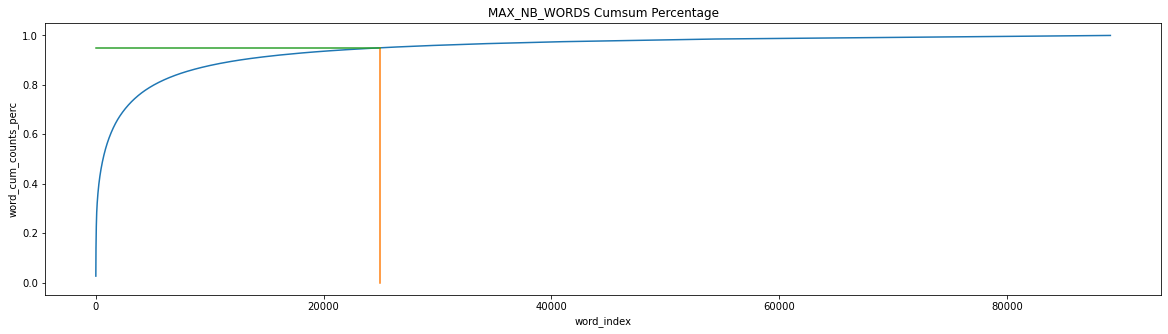

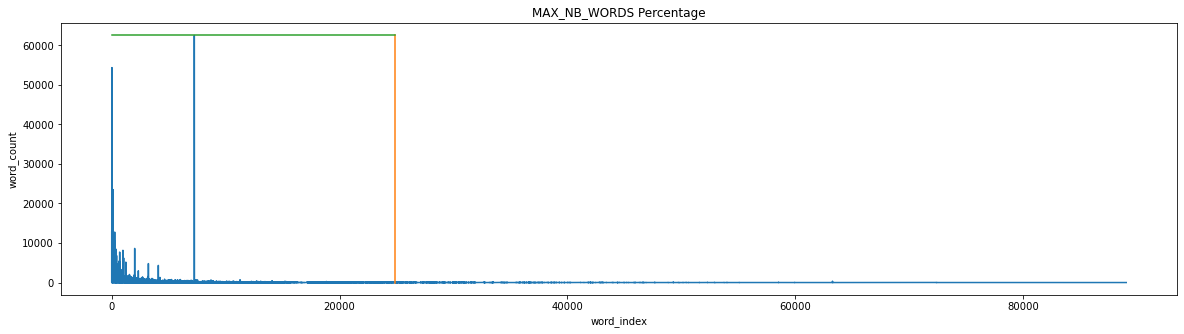

Cut index with 95.0 % of corpus:  24906 

    index          word  count
0    7251            ax  62520
1      22             i  54386
2       6             s  25670
3     126             t  23517
4       4           edu  21322
5     125             n  20680
6      35           the  19022
7     115             m  16981
8      27            it  13959
9       0          from  12815
10    264             x  12765
11    263           com  12291
12      8       subject  12265
13     21         lines  11837
14     85             a  11804
15     38            in  11668
16     16  organization  11233
17    254            re  10551
18     81             d  10269
19    248             w   8968


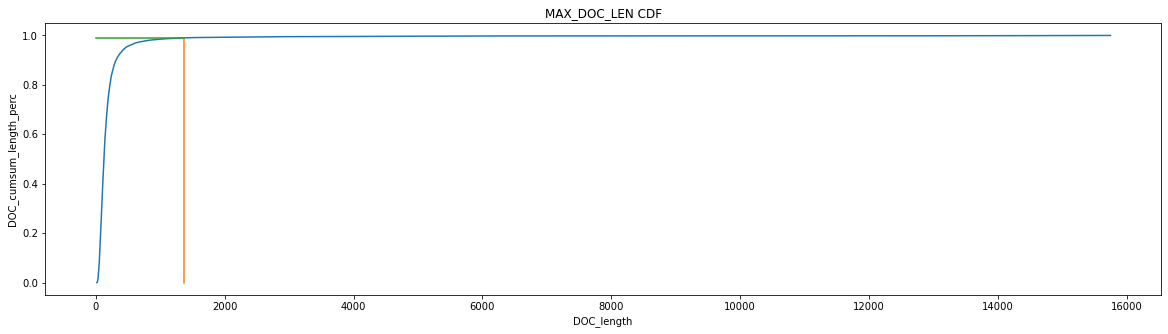

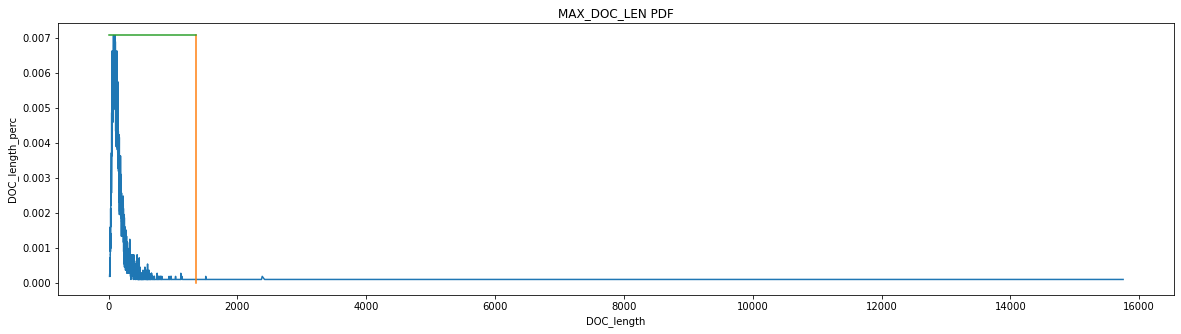

Cut index with 99.0 % of corpus:  1361


In [25]:
####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)


####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.95
MAX_DOC_LEN_ratio = 0.99
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [26]:
####################################
### train val test split
####################################
x_train_val, y_train_val, x_test, y_test = train_text, train_label, test_text, test_label
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

####################################
### preprocessor for NN input
####################################
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, train_text, filters=filters)
x_train = processor.generate_seq(x_train)
x_val = processor.generate_seq(x_val)
x_test = processor.generate_seq(x_test)
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)


print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))


info = pd.concat([y_train.value_counts(), y_val.value_counts(), y_val.value_counts()/y_train.value_counts(), y_train.value_counts()/y_train.size\
                 , y_test.value_counts(), y_test.value_counts()/y_test.size], axis=1)
info.index = labels
info.columns = ['tr_size', 'val_size', 'val_ratio', 'tr_prop', 'test_size', 'test_prop']
info

Shape of x_tr: (9051, 1361)
Shape of y_tr: (9051,)
Shape of x_val: (2263, 1361)
Shape of y_val: (2263,)
Shape of x_test: (7532, 1361)
Shape of y_test: (7532,)


,tr_size,val_size,val_ratio,tr_prop,test_size,test_prop
0,384,96,0.250000,0.042426,319,0.042353
1,467,117,0.250535,0.051597,389,0.051646
2,473,118,0.249471,0.052259,394,0.052310
3,472,118,0.250000,0.052149,392,0.052045
4,463,115,0.248380,0.051155,385,0.051115
5,474,119,0.251055,0.052370,395,0.052443
6,468,117,0.250000,0.051707,390,0.051779
7,475,119,0.250526,0.052480,396,0.052576
8,478,120,0.251046,0.052812,398,0.052841
9,478,119,0.248954,0.052812,397,0.052708


In [27]:
from collections import Counter, defaultdict
from gensim.models import word2vec
# from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from nltk import bigrams, trigrams, ngrams
from nltk.corpus import reuters, stopwords
from sklearn import preprocessing
# from tensorflow.keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim.downloader as api
import glob
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nltk, string
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string, os
import tensorflow as tf
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# TextCNN

## notes:

In [28]:
# define Model for classification

def model_Create(FS, NF, EMB, MDL, MNW, PWV=None, optimizer='RMSprop', trainable_switch=True):
    cnn_box = cnn_model_l2(FILTER_SIZES=FS, MAX_NB_WORDS=MNW, MAX_DOC_LEN=MDL, EMBEDDING_DIM=EMB,
                        NUM_FILTERS=NF, PRETRAINED_WORD_VECTOR=PWV, trainable_switch=trainable_switch)
    # Hyperparameters: MAX_DOC_LEN
    q1_input = Input(shape=(MDL,), name='q1_input')
    encode_input1 = cnn_box(q1_input)
    # half_features = int(len(FS)*NF/2)*10
    x = Dense(384, activation='relu', name='half_features')(encode_input1)
    x = Dropout(rate=0.3, name='dropout1')(x)
#     x = Dense(256, activation='relu', name='dense1')(x)
#     x = Dropout(rate=0.3, name='dropou2')(x)
    x = Dense(128, activation='relu', name='dense2')(x)
    x = Dropout(rate=0.3, name='dropout3')(x)
    x = Dense(64, activation='relu', name='dense3')(x)
    x = Dropout(rate=0.3, name='dropout4')(x)
    pred = Dense(len(labels), activation='softmax', name='Prediction')(x)
    model = Model(inputs=q1_input, outputs=pred)
    model.compile(optimizer=optimizer,
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model


EMBEDDING_DIM = 100
# W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
W2V = None
trainable_switch = True

In [29]:
# Set hyper parameters
FILTER_SIZES = [1, 2, 3, 4, 5]
NUM_FILTERS = 32

# OPT = optimizers.Adam(learning_rate=0.005)
OPT = optimizers.RMSprop(learning_rate=0.001) # 'RMSprop'
PWV = W2V
model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
                     MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, 
                     optimizer=OPT, trainable_switch=trainable_switch)

In [30]:
# visual_textCNN(model)

In [37]:
BATCH_SIZE = 512 # 先在小的batch上train, 容易找到全局最优部分, 然后再到 大 batch 上train, 快速收敛到局部最优
NUM_EPOCHES = 10  # 20步以上
patience = 20

file_name = 'test'
BestModel_Name = file_name + 'Best_GS_2'
BEST_MODEL_FILEPATH = BestModel_Name
# model.load_weights(BestModel_Name) # 这样就能接着上次train

earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
# history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
model.load_weights(BestModel_Name)

Epoch 1/10
18/18 [==============================] - 32s 2s/step - loss: 0.0808 - sparse_categorical_accuracy: 0.9764 - val_loss: 1.9822 - val_sparse_categorical_accuracy: 0.6802

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.68016, saving model to testBest_GS_2
INFO:tensorflow:Assets written to: testBest_GS_2\assets
Epoch 2/10
18/18 [==============================] - 18s 986ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9782 - val_loss: 1.7252 - val_sparse_categorical_accuracy: 0.7119

Epoch 00002: val_sparse_categorical_accuracy improved from 0.68016 to 0.71190, saving model to testBest_GS_2
INFO:tensorflow:Assets written to: testBest_GS_2\assets
Epoch 3/10
18/18 [==============================] - 15s 823ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9832 - val_loss: 1.8702 - val_sparse_categorical_accuracy: 0.7130

Epoch 00003: val_sparse_categorical_accuracy improved from 0.71190 to 0.71296, saving model to testBest_GS_2
INFO:tensorflow:Asset

loss val_loss


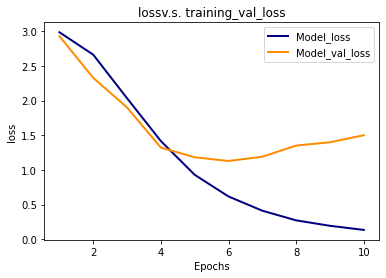

sparse_categorical_accuracy val_sparse_categorical_accuracy


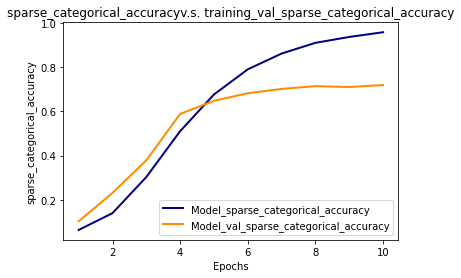

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       319
           1       0.49      0.48      0.48       389
           2       0.74      0.51      0.60       394
           3       0.69      0.62      0.65       392
           4       0.73      0.69      0.71       385
           5       0.54      0.71      0.61       395
           6       0.82      0.81      0.82       390
           7       0.86      0.70      0.77       396
           8       0.87      0.88      0.88       398
           9       0.80      0.85      0.82       397
          10       0.93      0.94      0.93       399
          11       0.84      0.93      0.88       396
          12       0.54      0.57      0.55       393
          13       0.67      0.74      0.70       396
          14       0.82      0.82      0.82       394
          15       0.94      0.76      0.84       398
          16       0.69      0.74      0.72       364
          17       0.92    

In [36]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
print(classification_report(y_test, np.argmax(y_pred, axis=1)))
# print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

In [ ]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

In [ ]:
y_pred = model.predict(x_train)
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(classification_report(train_label, np.argmax(y_pred, axis=1), target_names=labels))

# LSTM

In [ ]:
# from tensorflow.keras.layers import SpatialDropout1D, GlobalMaxPooling1D, GlobalMaxPooling2D

# def model_Create(FS, NF, EMB, MDL, MNW, PWV = None, optimizer='RMSprop', trainable_switch=True):
#     model = Sequential()
#     model.add(Embedding(input_dim=MNW, output_dim=EMB, embeddings_initializer='uniform', mask_zero=True, input_length=MDL))
#     model.add(Flatten())   
# #     model.add(GlobalMaxPooling2D()) # downsampling
# #     model.add(SpatialDropout1D(0.2))    
#     model.add(Dense(1024, activation='relu'))   
#     model.add(Dense(512, activation='relu'))   
#     model.add(Dense(128, activation='relu'))   
#     model.add(Dense(64, activation='relu'))   
#     # model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#     model.add(Dense(20, activation='softmax'))   
#     model.compile(optimizer=optimizer,
#           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#           metrics=[keras.metrics.SparseCategoricalAccuracy()])
#     return model

# model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, EMB=EMBEDDING_DIM,
#                      MDL=MAX_DOC_LEN, MNW=MAX_NB_WORDS+1, PWV=PWV, trainable_switch=trainable_switch)

In [ ]:
# visual_textCNN(model)

In [ ]:
# EMBEDDING_DIM = 200
# # W2V =  processor.w2v_pretrain(EMBEDDING_DIM, min_count=2, seed=1, cbow_mean=1,negative=5, window=20, workers=7) # pretrain w2v by gensim
# # W2V = processor.load_glove_w2v(EMBEDDING_DIM) # download glove
# trainable_switch = True
# W2V = None

In [ ]:
# BATCH_SIZE = 64
# NUM_EPOCHES = 10  # patience=20
# patience = 30

# BestModel_Name = 'text_CNN.h5'
# BEST_MODEL_FILEPATH = BestModel_Name

# earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
# checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
# model.load_weights(BestModel_Name)

In [ ]:
# #### classification Report
# history_plot(history)
# y_pred = model.predict(x_test)
# # print(classification_report(y_test, np.argmax(y_pred, axis=1)))
# print(classification_report(test_label, np.argmax(y_pred, axis=1), target_names=labels))
# scores = model.evaluate(x_test, y_test, verbose=2)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print( "\n\n\n")